In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
from pandas.tseries.offsets import DateOffset



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
# 데이터 로드하기
from google.colab import drive
drive.mount('/content/gdrive')

warnings.filterwarnings("ignore")
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/deep/stock_pre_5Y.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
# 랜덤시드 고정시키기
seed = 5
np.random.seed(seed)


In [13]:
#데이터셋의 5행까지 출력
df.head()

,Date,Close
0,2015-12-14,4952.229980
1,2015-12-15,4995.359863
2,2015-12-16,5071.129883
3,2015-12-17,5002.549805
4,2015-12-18,4923.080078


In [14]:
# date 인덱스 설정
df.reset_index()
df=df.set_index('Date')

In [15]:
df.head()

,Close
Date,
2015-12-14,4952.229980
2015-12-15,4995.359863
2015-12-16,5071.129883
2015-12-17,5002.549805
2015-12-18,4923.080078


In [16]:
# 훈련,시험데이터 나누기
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size=0.2, shuffle=False)

In [17]:
# 정규화 하기
scaler=MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)


In [18]:
n_input=20        #입력 개수   날짜 따라서 바꾸기
n_features=1      #독립변수의 수

generator=TimeseriesGenerator(train, train,length=n_input, batch_size=15)

model = Sequential()

model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=300)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0357
Epoch 2/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0015
Epoch 3/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0027
Epoch 4/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0019
Epoch 5/300
66/66 [==============================] - 2s 30ms/step - loss: 0.0011
Epoch 6/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0020
Epoch 7/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0013
Epoch 8/300
66/66 [==============================] - 2s 30ms/step - loss: 0.0013
Epoch 9/300
66/66 [==============================] - 2s 29ms/step - loss: 0.0013
Epoch 10/300
66/66 [==============================] - 2s 30ms/step - loss: 0.0018
Epoch 11/300
66/66 [==============================] - 2s 30ms/step - loss: 9.5854e-04
Epoch 12/300
66/66 [=======

In [20]:
# 예측값 데이터로 정리하기 --> 날짜를 인덱스로 주기 위한 과정
pred_list=[]
batch=train[-n_input:].reshape((1, n_input, n_features))
#print(batch)

for i in range(n_input):
    pred_list.append(model.predict(batch
                                   )[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)


In [21]:
# 실제값 예측값 데이터 셋 및 비교

df_predict=pd.DataFrame(scaler.inverse_transform(pred_list),index=df[-n_input:].index, columns=['Predictions'])
df_test=pd.concat([df,df_predict],axis=1)

In [22]:
df_test.tail()

,Close,Predictions
2020-12-07,12519.95020,8385.684073
2020-12-08,12582.76953,8369.367624
2020-12-09,12338.95020,8353.298405
2020-12-10,12405.80957,8337.473764
2020-12-11,12377.87012,8321.884152


In [23]:
#RMSE 구하기 -평가지표
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [3696.70210124]


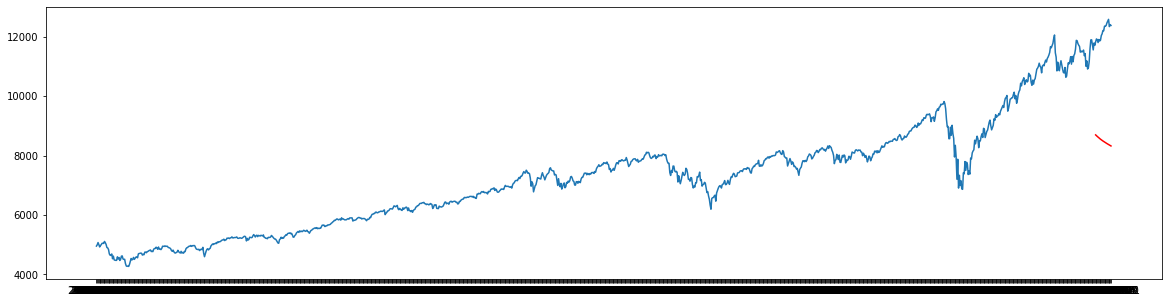

In [25]:
# 그래프 표현
plt.figure(figsize=(20,5))
plt.plot(df_test.index, df_test['Close'])   
plt.plot(df_test.index, df_test['Predictions'],color='r')
plt.show()

In [ ]:
train=df    

scaler.fit(train)
train=scaler.transform(train)

n_input=20    #날짜 따라서 바꾸기
n_features=1

generator=TimeseriesGenerator(train, train,length=n_input, batch_size=15)

model.fit_generator(generator, epochs=300)



pred_list=[]
batch=train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)

In [29]:
'''
# 오류가 날 수 있음!! - 오류가 나는 경우 밑에 코드로
from pandas.tseries.offsets import DateOffset
add_dates=[df.index[-1]+DateOffset(days=x)for x in range(0,21)]
future_dates=pd.DataFrame(index=add_dates[1:], columns=df.columns)
'''

'\n# 오류가 날 수 있음!! - 오류가 나는 경우 밑에 코드로\nfrom pandas.tseries.offsets import DateOffset\nadd_dates=[df.index[-1]+DateOffset(days=x)for x in range(0,21)]\nfuture_dates=pd.DataFrame(index=add_dates[1:], columns=df.columns)\n'

In [30]:
'''
future_dates.tail()
'''

'\nfuture_dates.tail()\n'

In [34]:
import datetime
from pandas.tseries.offsets import DateOffset
b = df.index[-1]
add_dates = [b]
for i in range(0,21):
  add = DateOffset(days=i)
  add_dates.append(add)
print('ok')

future_dates=pd.DataFrame(index=add_dates[1:], columns=df.columns)
#print(future_dates)

ok


In [35]:
future_dates.tail()

,Close
<DateOffset: days=16>,NaN
<DateOffset: days=17>,NaN
<DateOffset: days=18>,NaN
<DateOffset: days=19>,NaN
<DateOffset: days=20>,NaN


In [36]:
df_predict=pd.DataFrame(scaler.inverse_transform(pred_list),
                        index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj=pd.concat([df,df_predict],axis=1)

In [37]:
#예측결과
df_proj.tail(20)

'''
day 7,8,9 가 각각 22,23,24
'''

,Close,Prediction
<DateOffset: days=1>,NaN,12456.838126
<DateOffset: days=2>,NaN,12480.213831
<DateOffset: days=3>,NaN,12518.665279
<DateOffset: days=4>,NaN,12545.379803
<DateOffset: days=5>,NaN,12571.154541
<DateOffset: days=6>,NaN,12595.330749
<DateOffset: days=7>,NaN,12619.605596
<DateOffset: days=8>,NaN,12644.503992
<DateOffset: days=9>,NaN,12670.269808
<DateOffset: days=10>,NaN,12696.789039


In [40]:
# Dateoff가 오류가 나지 않으면 실행됨
'''
plt.figure(figsize=(10,4))
plt.plot(df_proj.index, df_proj['Close'])
plt.plot(df_proj.index, df_proj['Prediction'],color='r')
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
'''

"\nplt.figure(figsize=(10,4))\nplt.plot(df_proj.index, df_proj['Close'])\nplt.plot(df_proj.index, df_proj['Prediction'],color='r')\nplt.legend(loc='best', fontsize='large')\nplt.xticks(fontsize=12)\nplt.yticks(fontsize=12)\nplt.show()\n"